In [64]:
# coding: utf-8# codin 
import pandas as pd
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
from datetime import datetime
from PIL import Image
from os import path
import matplotlib.patches as mpatches
import random
import callDB as cd

%matplotlib inline  

font_name='Malgun Gothic'
sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=1.4,
        rc = {'font.size': 12, 'font.family':font_name})

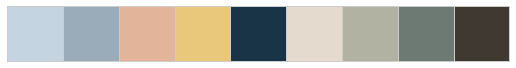

In [65]:
col_pal = "#C4D4E0 #9AABB9 #E2B49A #E9C77B #193446 #E5DACE #B2B2A2 #6D7973 #3F3931".split()
sns.palplot(col_pal)

In [66]:
log_in_documents = cd.readDB()
log_out_documents = cd.readDB2()

In [27]:
def str2datetime(s):
    return datetime.strptime(s, '%Y-%m-%d')
            
def makeVisualizationTable(document_table, official_doc_status):
    return_processed_table = []
    cnt = 0
    for i, row in enumerate(document_table):
        if(row[5] != None):
            return_processed_table.append([])
            #return_processed_table[cnt].append(row[0])               # No.
            return_processed_table[cnt].append(official_doc_status)  # Status
            return_processed_table[cnt].append(row[1])               # Document Code
            return_processed_table[cnt].append(row[2])               # Document Title
            return_processed_table[cnt].append(row[3])               # Issue From
            return_processed_table[cnt].append(row[4])               # Issue Timedelta
            return_processed_table[cnt].append(str2datetime(row[5]))  # Issue Date
            return_processed_table[cnt].append(int(row[5][:4]))           # Issue Year
            return_processed_table[cnt].append(int(row[5][5:7]))          # Issue Month
            return_processed_table[cnt].append(int(row[5][8:10]))         # Issue Day            
            return_processed_table[cnt].append(row[7])               # Responsed Document
            return_processed_table[cnt].append(row[8])               # Response Timedelta
            if(row[9] != None):
                return_processed_table[cnt].append(str2datetime(row[9]))  # Response Date
                return_processed_table[cnt].append(int(row[9][:4]))       # Response Year
                return_processed_table[cnt].append(int(row[9][5:7]))      # Response Month
                return_processed_table[cnt].append(int(row[9][8:10]))     # Response Day
            else:
                return_processed_table[cnt].append(None)
                return_processed_table[cnt].append(None)
                return_processed_table[cnt].append(None)
                return_processed_table[cnt].append(None)
            cnt += 1

    return return_processed_table

In [69]:
in_table = makeVisualizationTable(log_in_documents,"In")
out_table = makeVisualizationTable(log_out_documents,"Out")
total_table = in_table+out_table

In [72]:
cols = ["Status", "Document_Code", "Document_Title", "Issue_From", "Issue_Timedelta", "Issue_Date",
       "Issue_Year", "Issue_Month", "Issue_Day", "Responsed_Document", "Response_Timedelta",
       "Response_Date", "Response_Year", "Response_Month", "Response_Day"]
dataframe_total=pd.DataFrame(total_table, columns=cols)
dataframe_total=dataframe_total.sort_values(by='Issue_Timedelta').reset_index(drop=True)

,Status,Document_Code,Document_Title,Issue_From,Issue_Timedelta,Issue_Date,Issue_Year,Issue_Month,Issue_Day,Responsed_Document,Response_Timedelta,Response_Date,Response_Year,Response_Month,Response_Day
0,In,MRPSC/015/10-11/2080/11,Invitation to Tender,ASHGHAL,40591.0,2011-02-17,2011,2,17,,,NaT,NaN,NaN,NaN
1,In,MRPSC/015/10-11/2423/11,Response to Tender Query,ASHGHAL,40603.0,2011-03-01,2011,3,1,,,NaT,NaN,NaN,NaN
2,In,MRPSC/015/10-11/3496,Tender Submission Date,ASHGHAL,40654.0,2011-04-21,2011,4,21,,,NaT,NaN,NaN,NaN
3,In,MRPSC/015/10-11/4247,Tender Submission Date(Final Extension),ASHGHAL,40701.0,2011-06-07,2011,6,7,,,NaT,NaN,NaN,NaN
4,In,DXW-P003-0000-CP-KBR-LT-01146,Tender Presentation,KBR,40797.0,2011-09-11,2011,9,11,,,NaT,NaN,NaN,NaN


In [30]:
dataframe_total['days'] = dataframe_total['Issue_Timedelta'].apply(lambda x : int(x-dataframe_total['Issue_Timedelta'].min()))
dataframe_total['total']=' '

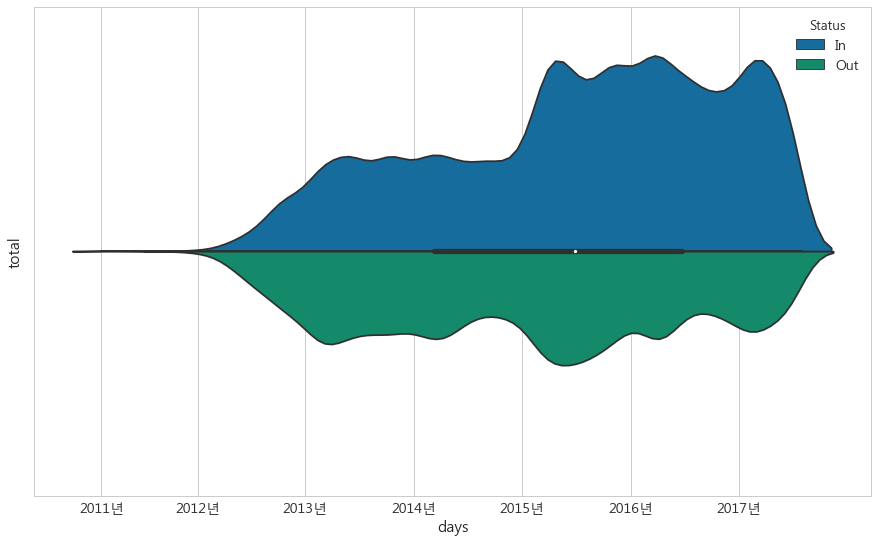

In [31]:
plt.figure(figsize=(15,9))
sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=1.4,
        rc = {'font.size': 12, 'font.family':font_name})
sns.violinplot(data=dataframe_total, x='days', y='total', hue='Status',split=True, 
               orient='h', width=.8,  cut=2, bw=.1, scale='count', colors=col_pal)
## draw x-ticks
ticks = dataframe_total.groupby("Issue_Year").min()[["days"]]
#plt.xlim(0,1900)
xticks = plt.xticks( ticks.days.tolist(), [ "%d년" % m for m in ticks.index.tolist()] )

1. dd
2. dd
3. dff


In [58]:
import math

replace_chars = ":_![]/()'\",-&"
exclude_words = set(('safety', 'report', 'at', 'c', 'not', 'or', 'its', 'by', 'a', 'with', 'for',
                     'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',
                     'of', 'no', 'and', 'the', 'in', 'on', 'to', 'no.',
                     '2014', '2015', '2016', '2017', '2013', '2012'))


def tokenize(string):
    string = string.lower()
    for ch in replace_chars:
        string = string.replace(ch, ' ')
    words = [word for word in string.split()
             if (word not in exclude_words) and (len(word) > 1) and (not word[0].isnumeric())
             ]
    return words


def group_func(x):
    return '%d-%02d' % (x.year, math.floor((x.month-1)/3)*3)


def makeCorpus(ds, target):
    corpus = []
    idx2name = []

    for (name, group) in ds.groupby(ds['Issue_Date'].apply(group_func)):
        group_corpus = []
        for string in group[target].values:
            group_corpus.extend(tokenize(string))
        corpus.append(group_corpus)
        idx2name.append(name)
    return (corpus, idx2name)

In [59]:
(subject_corpus, idx2group) = makeCorpus(dataframe_total, 'Document_Title')

In [60]:
from  gensim import corpora, models, similarities
from time import time
import operator

dictionary = corpora.Dictionary(subject_corpus)

# compile corpus (vectors number of times each elements appears)
raw_corpus = [dictionary.doc2bow(t) for t in subject_corpus]

# Transform Text with TF-IDF
tfidf = models.TfidfModel(raw_corpus) # step 1 -- initialize a model

In [61]:
topic_word_list = []
topic_score_list = []
topic_word_count = 100

for (idx, src_name) in enumerate(idx2group):
    topic = tfidf[raw_corpus[idx]]
    src_name = src_name.lower()
    topic = [ (dictionary[word], score) for (word,score) in topic ]
    topic = sorted(topic, key=operator.itemgetter(1), reverse=True)
    
    topic_word_list.append( [ word for word, score in topic[:topic_word_count]] )
    topic_score_list.append( [ score for word, score in topic[:topic_word_count]] )

In [62]:
topic_score_ds = pd.DataFrame( topic_score_list, index=idx2group )
topic_score_ds.fillna(0, inplace=True)
topic_word_ds = pd.DataFrame( topic_word_list, index=idx2group )
topic_word_ds.fillna('', inplace=True)

## cut letters to 10
topic_word_ds = topic_word_ds.applymap(lambda x: x[:10])

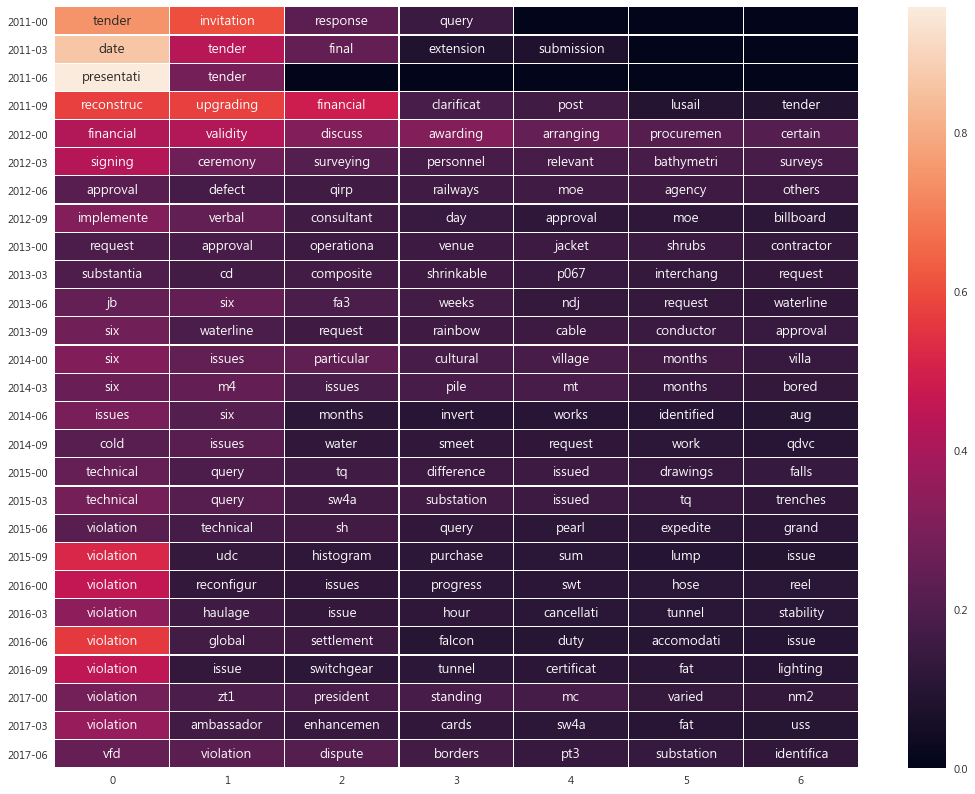

In [63]:
sns.set(style="whitegrid", palette="colorblind", color_codes=True, font_scale=1.1, font=font_name )
plt.figure(figsize=(18,14))
ax = sns.heatmap(topic_score_ds.loc[:,:6], annot=topic_word_ds.loc[:,:6].values, fmt="", linewidths=.2)